# Model Selection

---

__This Notebook__

- plot learning curves to assess overfitting

__Results__ 


## Setup

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedKFold, learning_curve
from sklearn.metrics import make_scorer, accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-12


## Load

In [2]:
# load target 
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())
y = y_array.copy()
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load matrix
proc_dir = os.path.join("data", "2_processed")
X = sp.load_npz(os.path.join(proc_dir, 'X_tfidf_svd800_spamcos.npz'))

## Learning Curves

In [77]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),
                        verbose=1, scoring=None):
    scorers = {
        'Accuracy': make_scorer(accuracy_score),
        'Sensitivity': make_scorer(recall_score, pos_label=1), 
        'Specificity': make_scorer(recall_score, pos_label=0) 
    }
    scorer_ = scorers[scoring]
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 12))
        
    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, verbose=verbose,
                       train_sizes=train_sizes, n_jobs=n_jobs,
                       scoring=scorer_, return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="lower right")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")

    return plt

In [80]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

title1 = r"Learning Curves (GGC, 100 trees and features, depth 1)"
title2 = r"Learning Curves (GBC, 100 trees and features, depth 2)"

estimator1 = GradientBoostingClassifier(
    random_state=42,
    max_depth=1,
    max_features=100,
    n_estimators=100
)

estimator2 = GradientBoostingClassifier(
    random_state=42,
    max_depth=2,
    max_features=100,
    n_estimators=100
)

[learning_curve] Training set sizes: [ 312 1014 1716 2418 3120]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   42.0s finished


[learning_curve] Training set sizes: [ 312 1014 1716 2418 3120]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   58.8s finished


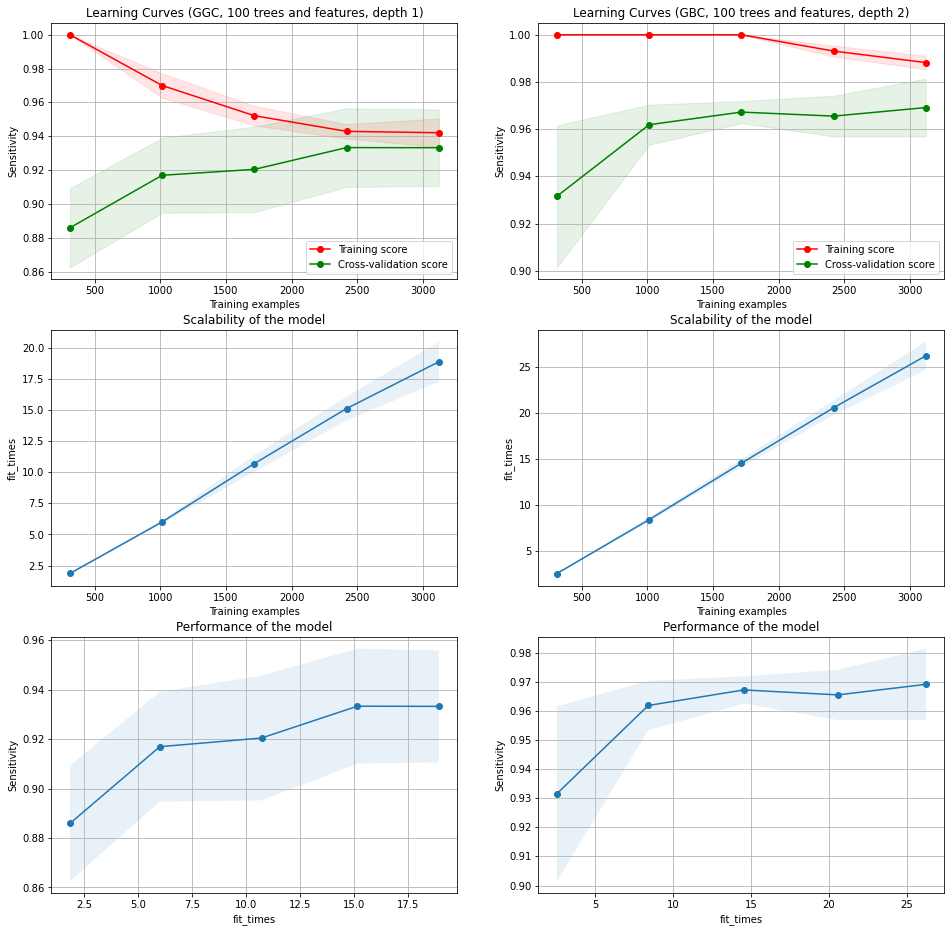

In [81]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
plot_learning_curve(estimator1, title1, X, y, scoring='Sensitivity', axes=axes[:, 0], cv=cv, n_jobs=-1)
plot_learning_curve(estimator2, title2, X, y, scoring='Sensitivity', axes=axes[:, 1], cv=cv, n_jobs=-1)
plt.show()

---